In [1]:
from scipy import interpolate
import eryn
from numpy import random
import numpy as np
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from chainconsumer import ChainConsumer
import corner
import matplotlib.pyplot as plt
from eryn.moves import GaussianMove
from spectral import genTimeSeriesFromPSD, lpsd, welchpsd
from scipy.stats import chi2, norm


class noise_model:
    """
      Class for the nosie model. We only need the f-vector to evaluate it
    """
    def __init__(self, fvec):
        self._f = np.array(fvec) # Ensure we get cuda array
        
    def eval(self, params):
        """LISA noise model for AE channels. The parameters are the log-base-10 of the acceleration and 
            displacement noises.
        """
        params = np.array(params) # <---- Ensure it's a numpy or cupy array
        # Be careful with the dimensions here
        if params.ndim == 1:
            Sa, Si = params[:,None]
        else:
            Sa, Si = params[:,0], params[:,1]
        x   = 2.0 * np.pi * lisaLT * self._f
        Spm = 10**(Sa[:,None]) * (1.0 + (0.4e-3/self._f)**2) * (1.0+(self._f/8e-3)**4) * (2.0*np.pi*self._f)**(-4.) * (2.0*np.pi*self._f/clight)**2 
        Sop = 10**(Si[:,None]) * (1.0 + (2.e-3/self._f)**4) * (2.0 * np.pi * self._f/clight)**2
        S0  = 8.0 * np.sin(x)**2 * (2.0 * Spm * (3.0 + 2.0*np.cos(x) + np.cos(2.*x)) + Sop * (2.0 + np.cos(x)))
        return np.array(S0)
    def __call__(self, p):
        return self.eval(p)
    
def get_clean_chain(coords, ndim, temp=0):
    """Simple function to extract the squeezed chains for all the parameters
    """
    naninds    = np.logical_not(np.isnan(coords[:, temp, :, :, 0].flatten()))
    samples_in = np.zeros((coords[:, temp, :, :, 0].flatten()[naninds].shape[0], ndim))  # init the chains to plot
    # get the samples to plot
    for d in range(ndim):
        givenparam = coords[:, temp, :, :, d].flatten()
        samples_in[:, d] = givenparam[
            np.logical_not(np.isnan(givenparam))
        ]  # Discard the NaNs, each time they change the shape of the samples_in
    return samples_in


def get_clean_k_chains(backend, temp=0):
    """ A simple function to get the chains of model order k

    Args:
        backend: The Eryn backend

    Returns:
        k_chain: the chains of the k order        
    """
    inds = backend.get_value("inds")  # Get the leaves out
    branches = {name: np.sum(inds[name], axis=-1, dtype=int) for name in inds}
    for (branch) in (branches):  # Get the total number of components/branches per temperature
        if branch == list(branches.keys())[0]:
            k_chain = branches[branch][:, temp].flatten()
        else:
            k_chain += branches[branch][:, temp].flatten()
    return k_chain



def genTimeSeriesFromPSD2(S,fs):
    """ genTimeSeriesFromPSD (S,fs)

    A simple function to generate time series from a given *one-sided* power spectrum
    via iFFT. It draws the amplitudes from a chi2 distribution, while it asigns
    a random phase between [-2*pi, 2*pi].

    NK 2019
    """

    N    = 2*(len(S)-1)
    Ak   = np.sqrt(N*S/2*fs)             # Take the sqrt of the amplitude
    Ak   = np.append(Ak, Ak[1:-1][::-1]) # make two-sided
    rphi = np.zeros(N)

    rphi[1:int(N/2)-1]   = 2*np.pi*np.random.uniform(0, 1, int(N/2)-2)  # First half
    rphi[int(N/2)]       = 2*np.pi*round(np.random.uniform(0, 1))       # mid point
    rphi[int(N/2+1):N-1] = -rphi[1:int(N/2)-1][::-1]                    # reflected half

    X = Ak*np.sqrt(chi2.rvs(2, size=N)/2) * np.exp(1j * rphi)

    return np.fft.irfft(X,n=int(N)) # return Inverse FFT


clight = 299792458.0
lisaLT = 2.5e9/clight

Sa = np.log10((3.e-15)**2)  # m^2/sec^4/Hz
Si = np.log10((15.e-12)**2) # m^2/Hz

In [2]:
def powerlaw(f):
    return 10*f**(1/3)


def logS_inter(logf, knot_freqs, knot_values):
    logSm = interpolate.interp1d(knot_freqs, knot_values, kind = 'cubic', bounds_error=False, fill_value='extrapolate', assume_sorted = True)
    return logSm(logf)


def log_likelihood(pars, logf0, logf1, logf, logd, Kavs, mdist, lowlim, uplim):
    
    knots, edges = pars
    knots = np.array(knots)
    knots = knots[knots[:,0].argsort()]
    knot_freqs = knots[:,0]
    knot_freqs = [logf0] + list(knot_freqs) + [logf1]
    
    if np.any(np.diff(knot_freqs) < mdist):
        return - 10**6
    
    knot_values = knots[:,1]
    knot_values = [edges[0][0]] + list(knot_values) + [edges[0][1]]
    logS = logS_inter(logf, knot_freqs, knot_values)
    
    if np.any(logS < lowlim) | np.any(logS > uplim):
        return - 10**6
    
    L_arr = Kavs*(logS + np.exp(logd-logS))
    L = -0.5*L_arr.sum()
    
    return L

In [3]:
Tobs  = 1e7          # Duration of data
dt    = 15                      # Delta-t [s]
fs    = 1/dt                    # Sampling frequency
Ndata = int(Tobs/dt)            # Number of data points
tvec  = np.arange(0, Tobs, dt)  # Get the time vector
df    = 1.0/Tobs                # Define Delta-f

if (Ndata % 2)==0:              # Get the number of requencies
    nfft = int((Ndata/2)+1)
else:
    nfft = int((Ndata+1)/2)

F     = df*nfft                 # make the positive frequency vector
fvec  = np.arange(0, F, df)

S = powerlaw(fvec)
S[0]=0


my_data = genTimeSeriesFromPSD2(S, fs)

f0 = 1e-4
f1 = 3e-2

fl, Sl, Sle, _, Kavs = lpsd(my_data, fs, Kdes=100, Jdes=200, flims=[f0, f1], win='nuttall4b', winalpha=0., olap=0.0, order=0, errrype='std', DOPLOT=False, VERBOSE=False)
errs = [np.absolute(Sle[0]), np.absolute(Sle[1])]

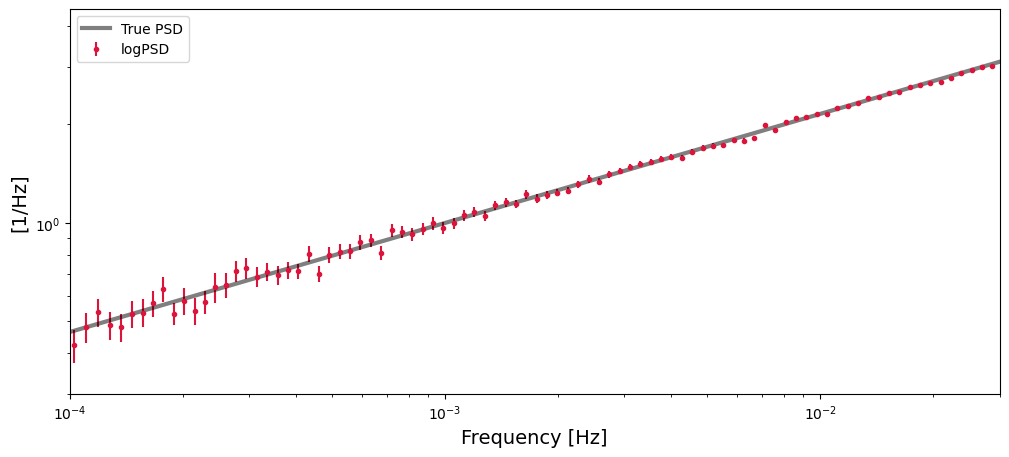

In [10]:
plt.figure(figsize=(12,5))
plt.errorbar(fl, np.absolute(Sl), yerr=errs, fmt='.', label='logPSD', color='crimson')
plt.loglog(fvec[1:], S[1:], alpha=0.5, color='k', linewidth=3, label='True PSD')
plt.xlim(f0, f1)
plt.ylabel('[1/Hz]', fontsize = 14)
plt.xlabel('Frequency [Hz]', fontsize = 14)
plt.ylim(3e-1, 4.5)
plt.legend(loc = 'upper left')
plt.savefig('/Users/ngalanis/VSCode Pictures/highQ/logPSD.pdf', bbox_inches='tight', dpi=600)
plt.show()

In [5]:
logf0 = np.log(f0)
logf1 = np.log(f1)

s0 = np.log(powerlaw(f0))
s1 = np.log(powerlaw(f1))

mdist = 0.1
lowlim = s0 - 1 
uplim = s1 + 1
logf = np.log(fl)
logd = np.log(np.abs(Sl))

branch_names = ["knots", "edges"]

nwalkers = 20
ndims = [2, 2]
nleaves_max = [8, 1]
nleaves_min = [2, 1]
ntemps = 10

priors = {
    "knots" : {
        0 : uniform_dist(logf0 + mdist, logf1 - mdist),
        1 : uniform_dist(s0 - 1, s1 + 1)
    },
    "edges" : {
        0 : uniform_dist(s0 - 1, s0 + 1),
        1 : uniform_dist(s1 - 1, s1 + 1)
    }
}

factor = 0.0001
cov = {"knots" : np.identity(ndims[0])*factor,
       "edges" : np.identity(ndims[1])*factor}

moves = GaussianMove(cov)

ensemble = EnsembleSampler(
                    nwalkers,
                    ndims,
                    log_likelihood,
                    priors,
                    args = [logf0, logf1, logf, logd, Kavs, mdist, lowlim, uplim],
                    tempering_kwargs=dict(ntemps=ntemps),
                    nbranches=len(branch_names),
                    branch_names=branch_names,
                    nleaves_max=nleaves_max,
                    nleaves_min=nleaves_min,
                    moves = moves,
                    rj_moves = True)

In [6]:
a = np.ones(shape=(ntemps, nwalkers, 2), dtype=bool)
b = np.zeros(shape=(ntemps, nwalkers, nleaves_max[0]-2), dtype=bool)

inds = {
    "knots" : np.concatenate((a, b), axis = 2),
    "edges" : np.ones(shape=(ntemps, nwalkers, nleaves_max[1]), dtype=bool)
}

coords = {
    "knots" : np.zeros((ntemps, nwalkers, nleaves_max[0], ndims[0])),
    "edges" : np.zeros((ntemps, nwalkers, nleaves_max[1], ndims[1]))
}

for name, leaves, dims in zip(branch_names, nleaves_max, ndims):
    for d in range(dims):
        coords[name][:, :, :, d] = priors[name][d].rvs(size=(ntemps, nwalkers, leaves))


state = State(coords, inds=inds)

In [7]:
nsteps = 2000

out = ensemble.run_mcmc(state, nsteps, burn = 100, progress=True)

100%|██████████| 2000/2000 [01:06<00:00, 30.22it/s]


/var/folders/qr/2my9y2b100zbn7vs_cvll36r0000gn/T/ipykernel_41915/2654888764.py:14: RuntimeWarning: divide by zero encountered in log
  ax_list[0].plot(np.log(fvec), np.log(powerlaw(fvec)), color='k', lw=1.5,linestyle='--')


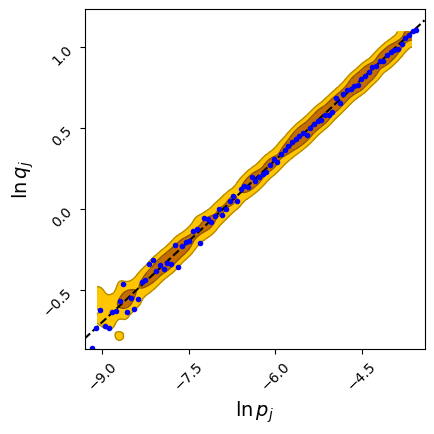

In [8]:
ndim_knots = 2 # Set the dimensionality of each model
ndim_edges = 2

samples_knots = get_clean_chain(ensemble.backend.get_chain()['knots'], ndim_knots)
samples_edges = get_clean_chain(ensemble.backend.get_chain()['edges'], ndim_edges)

paramnames = [r'$\ln p_j$',r'$\ln q_j$'] # Define parameter names

c = ChainConsumer()
c.add_chain(samples_knots, parameters=paramnames, name='Knots in-between', color='orange')
c.configure(bar_shade=True, plot_hists=False)
fig = c.plotter.plot(figsize=(4, 4))
ax_list = fig.axes
ax_list[0].plot(np.log(fvec), np.log(powerlaw(fvec)), color='k', lw=1.5,linestyle='--')
plt.errorbar(logf, logd, fmt='.', label='logPSD', color='b')
plt.xlim(logf0-0.1, logf1+0.1)
plt.ylim(s0-0.1,s1+0.1)
plt.xlabel(r'$\ln p_j$', fontsize = 14)
plt.ylabel(r'$\ln q_j$', fontsize = 14)
plt.savefig('/Users/ngalanis/VSCode Pictures/highQ/only_sgwb_sampling.pdf', bbox_inches='tight', dpi=600)
plt.show()

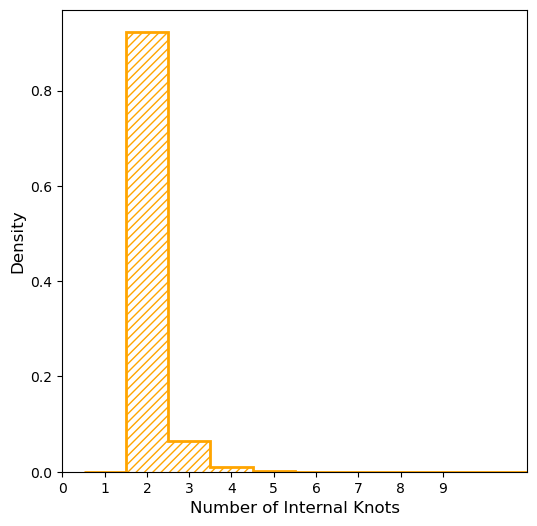

In [9]:
knots_k_chain = get_clean_k_chains(ensemble.backend)

bns = (np.arange(1, 20 + 2) - 0.5)  # Get maximum allowed number of leaves for the given branch 

fig = plt.figure(figsize=(6, 6))
probs, bins, rects = plt.hist(
        knots_k_chain-1,
        bins=bns,
        facecolor=None,
        histtype='step',
        edgecolor='orange',
        hatch='////',
        alpha=1,
        lw=2,
        density=True,
        )


plt.xticks(np.arange(0, 10))
plt.xlim(0, 11)
plt.xlabel(r"Number of Internal Knots", fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.savefig('/Users/ngalanis/VSCode Pictures/highQ/number of knots.pdf', bbox_inches='tight', dpi=600)
plt.show()